# Fitting All Wavelengths Using PandExo and Juliet 
--------
Here we preform similar calculations to notebook I ([I. Introduction to the problem](https://github.com/nespinoza/PandExoVSjuliet/blob/master/I.%20Introduction%20to%20the%20problem.ipynb)). In this example, we perform light curve fitting with Juliet for all wavelenghts of our simulated transit spectrum from PandExo.

Once all of the model fitting is performed, we then compare the percent difference of the calculated error in the transit flux between PandExo and Juliet by plotting the differences.

We then write the data used for these figures out to `transit_depth_error_data.csv`.

### Load Libraries

In [1]:
import batman
import dask
import juliet
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import interp1d

### Load Simulated PandExo Transit Spectrum for HAT-P-1b.

In [2]:
data = pickle.load(open('data/ETC-calculationc0e1784d-d070-49bd-9536-8c5183c58fa4e.p','rb'))

In [3]:
var_out, var_in = data['RawData']['var_out'], data['RawData']['var_in']
S_out, S_in = data['RawData']['electrons_out'], data['RawData']['electrons_in']
N_out, N_in = data['timing']['Num Integrations Out of Transit'], data['timing']['Num Integrations In Transit']

In [4]:
variance_delta = (((N_out / N_in) * (1. / S_out))**2) * var_in + \
                 (((N_out / N_in) * (S_in / S_out**2))**2) * var_out

variance_Fj = (var_out * N_out)/(S_out**2)

#### The following function returns a transit lightcurve centered around time $t_0 = 0$:

In [5]:
def transit_model(t, inc, w):
    """
    Given a time array t, an inclination "inc" and a wavelength in microns "w", this function returns 
    a lightcurve model including limb-darkening.
    """
    params = batman.TransitParams()
    params.t0 = 0. # time of inferior conjunction
    params.per = P # orbital period (days)
    params.a = a # semi-major axis (in units of stellar radii)
    params.rp = rp
    params.inc = inc # orbital inclination (in degrees)
    params.ecc = ecc # eccentricity
    params.w = omega # longitude of periastron (in degrees) p
    params.limb_dark = 'quadratic' # limb darkening profile to use
    if w<np.min(wld):
        c1,c2 = f1(np.min(wld)),f2(np.min(wld))
    elif w>np.max(wld):
        c1,c2 = f1(np.max(wld)),f2(np.max(wld))
    else:
        c1,c2 = f1(w), f2(w)
    
    params.u = [c1,c2] # limb darkening coefficients

    tmodel = batman.TransitModel(params, t.astype('float64'))
    return tmodel.light_curve(params)

#### Similar to notebook I, we create a time array for the light curve centered around 0. 

In [6]:
# First, create an array that goes from zero to 927. Multiply that by the time per integration (in days):
time_per_int = data['timing']['Time/Integration incl reset (sec)']/(3600.*24.)
nintegrations = data['timing']['APT: Num Integrations per Occultation']
t = np.arange(nintegrations) * time_per_int

# Now, if nintegrations is even, substract the mean between elements (nintegrations/2) and  (nintegrations/2)+1. 
# If odd, substract np.floor(nintegrations/2):
if nintegrations % 2 == 0:
    middle_mean = (t[int(nintegrations/2)] + t[int(nintegrations/2) + 1])*0.5
else:
    middle_mean = t[int(np.floor(nintegrations/2))]
t = t - middle_mean

#### Define the parameters that define the HAT-P-1B light curve.

In [7]:
P, a, inc, ecc, omega, rp = 4.4652998, 10.22, 85.79, 0., 90., 0.116

wld,u1,u2 = np.loadtxt('data/lds_order1.txt',unpack=True)
f1 = interp1d(wld,u1)
f2 = interp1d(wld,u2)

w_PandExo, deptherror_PandExo = data['FinalSpectrum']['wave'], data['FinalSpectrum']['error_w_floor']

In [8]:
# Generate models for each wavelength bin.
model_per_wavelength = [transit_model(t, inc, wavelength) for wavelength in w_PandExo]

In [9]:
lightcurve_errors = np.sqrt(variance_Fj)

# Generate array of noise for each wavelength bin.
noise_per_model = [np.random.normal(0., lightcurve_errors[i], len(t)) for i in range(len(lightcurve_errors))]

In [10]:
# Name of the parameters to be fit:
params = ['P_p1','t0_p1','p_p1','b_p1','q1_SOSS','q2_SOSS','ecc_p1','omega_p1',\
              'a_p1', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed','fixed','uniform','fixed','uniform','uniform','fixed','fixed',\
                 'fixed', 'fixed', 'normal', 'fixed']

# Hyperparameters
hyperps = [P, 0., [0.,1], a*np.cos(inc*np.pi/180.), [0., 1.], [0., 1.], ecc, omega,\
                   a, 1.0, [0.,0.1], 1e-6]

priors = juliet.generate_priors(params,dists,hyperps)

In [11]:
# Define starting point.
starting_point = {}
starting_point['p_p1'] = rp
starting_point['q1_SOSS'] = 0.5
starting_point['q2_SOSS'] = 0.5
starting_point['mflux_SOSS'] = 0.0

@dask.delayed
def load_and_fit_light_curves(time, wavelength, model, noise, error):
    """Load, fit and plot light curve data.
    """
    # Define time, flux and error dictionaries.
    times, fluxes, fluxes_error = {}, {}, {}
    times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = t, model + noise, \
                                                           np.ones(len(t))*error
    dataset = juliet.load(priors=priors, starting_point = starting_point, t_lc = times, y_lc = fluxes,\
                            yerr_lc = fluxes_error, out_folder = 'wavelength_{}_results'.format(wavelength))
    results = dataset.fit(sampler='emcee', progress=False)
    modelfit = results.lc.evaluate('SOSS')

    return results

# Build up dask delayed list.
all_wavelengths = []
for wavelength, model, noise, error in zip(w_PandExo, model_per_wavelength, noise_per_model, lightcurve_errors):
    result = load_and_fit_light_curves(t, wavelength, model, noise, error)
    all_wavelengths.append(result)

results = dask.delayed(all_wavelengths).compute(num_workers=16)

In [12]:
import pandas as pd

error_and_difference_data = {'wavelength':[], 'pandexo_err':[], 
                             'juliet_err':[], 'percent_difference':[]}
for result, wavelength, pandexo_error in zip(results, w_PandExo, deptherror_PandExo): 
    p = result.posteriors['posterior_samples']['p_p1']
    depth = p**2

    error_on_depth = np.sqrt(np.var(depth))
    pandexo_error = np.round(pandexo_error*1e6,1)
    juliet_error = np.round(error_on_depth*1e6,1)
    percent_diff = (juliet_error - pandexo_error) / juliet_error

    error_and_difference_data['wavelength'].append(wavelength)
    error_and_difference_data['pandexo_err'].append(pandexo_error)
    error_and_difference_data['juliet_err'].append(juliet_error)
    error_and_difference_data['percent_difference'].append(percent_diff)
    
data_table = pd.DataFrame(data=error_and_difference_data)

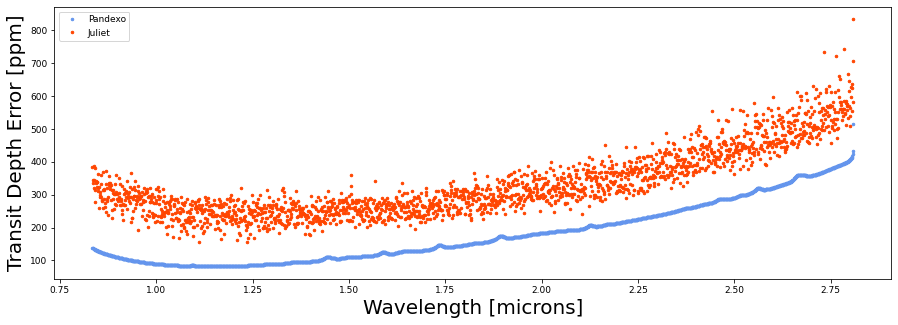

In [27]:
plt.figure(figsize=(15,5))

# Plot simulated data, along with the real model and the fitted model:
plt.plot(data_table['wavelength'], data_table['pandexo_err'], '.', color='cornflowerblue', label='Pandexo')
plt.plot(data_table['wavelength'], data_table['juliet_err'], '.', color='orangered', label='Juliet')
plt.xlabel('Wavelength [microns]', fontsize=20)
plt.ylabel('Transit Depth Error [ppm]', fontsize=20)
plt.legend()

In [14]:
data_table

,wavelength,pandexo_err,juliet_err,percent_difference
0,0.8348,139.3,382.9,0.636197
1,0.8357,137.9,343.6,0.598661
2,0.8367,136.8,336.8,0.593824
3,0.8377,135.9,387.6,0.649381
4,0.8386,135.1,320.5,0.578471
...,...,...,...,...
2031,2.8048,413.2,635.0,0.349291
2032,2.8058,416.9,554.0,0.247473
2033,2.8068,424.7,582.9,0.271402
2034,2.8077,434.1,706.4,0.385476


(array([ 29., 114., 240., 283., 280., 245., 217., 249., 259., 120.]),
 array([0.172346  , 0.22888138, 0.28541676, 0.34195214, 0.39848751,
        0.45502289, 0.51155827, 0.56809365, 0.62462903, 0.6811644 ,
        0.73769978]),
 <BarContainer object of 10 artists>)

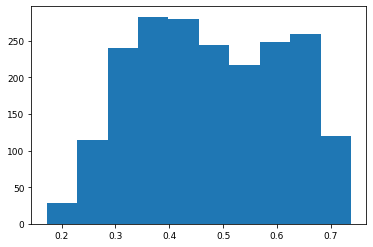

In [15]:
plt.hist(data_table['percent_difference'])

In [21]:
data_table.to_csv('transit_depth_error_data.csv')

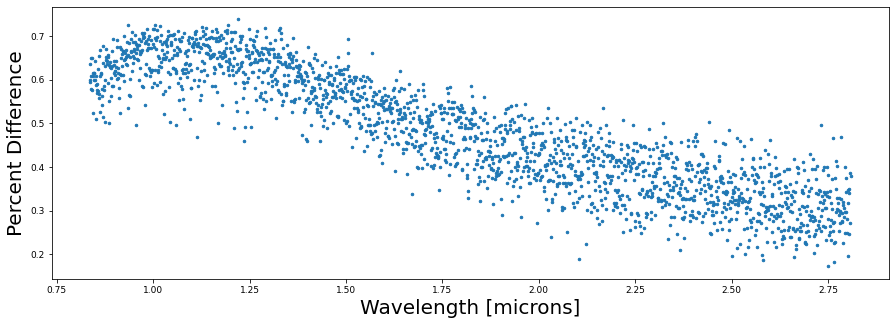

In [28]:
plt.figure(figsize=(15,5))

# Plot simulated data, along with the real model and the fitted model:
plt.plot(data_table['wavelength'], data_table['percent_difference'], '.')
plt.xlabel('Wavelength [microns]', fontsize=20)
plt.ylabel('Percent Difference', fontsize=20)